<div style="text-align:center;">
  <div style="background: linear-gradient(to right, #add8e6, #dda0dd); padding:15px 30px; border-radius:15px; display:inline-block;">
    <b style="color:black; font-size:32px;">🦋 Butterfly Image Classification (CNN) 🦋</b>
  </div>
</div>


<div style="
    background: #f3e8ff;
    border: 1px solid #d3bdf5;
    padding: 20px;
    box-sizing: border-box;
    width: 100%;
    color: #1b1b1b;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;
    box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15);
">
  <h2 style="margin-top: 0; color: #2a1748;"> Projenin Amacı</h2>
  <p style="font-size: 18px; line-height: 1.5;">
    Bu projenin amacı, farklı kelebek türlerine ait görüntüleri <strong>Convolutional Neural Network (CNN)</strong> mimarisini kullanarak bir kelebek
    türü sınıflandırma modeli geliştirmektir.Model, eğitim verilerinden öğrendiği özellikleri kullanarak yeni kelebek
    görüntülerini doğru bir şekilde tanımyı hedefler. Proje, sadece yüksek bir doğruluk skoru elde etmeyi değil, aynı zamanda modelin görsel verileri nasıl işlediğini ve karar mekanizmasını da anlamayı hedefler.
  </p>
</div>


<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
 Kütüphanelerin Import Edilmesi
</h2>


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from kerastuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")

print("TensorFlow version:", tf.__version__)
print("Is GPU avaliable ?", "Yes" if tf.config.list_physical_devices('GPU') else "No")


2025-09-26 00:06:15.421970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758845175.641145      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758845175.703261      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Is GPU avaliable ? Yes


/tmp/ipykernel_19/551310274.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


<div style="
    background: #f3e8ff;
    border: 1px solid #d3bdf5;
    padding: 20px;
    box-sizing: border-box;
    width: 100%;
    color: #1b1b1b;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;
    box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15);
    border-radius: 12px;
    margin: 12px 0;
">
  <p style="font-size: 16px; line-height: 1.6;">
    Projede, veri işleme, görselleştirme ve model oluşturma işlemleri için gerekli Python kütüphanelerini import ettik:
  </p>
  <ul style="font-size: 16px; line-height: 1.6; margin-left: 20px;">
    <li><code>warnings.filterwarnings("ignore")</code> → gereksiz uyarıları bastırma</li>
    <li>GPU kontrolü → modelin hızlandırılmış eğitimi için GPU üzerinde çalışmasını sağlama</li>
  </ul>
</div>


<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
 Veri Setini Okuma
</h2>


In [2]:
df = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")  # CSV dosyasını DataFrame olarak yükler
df.sample(10) # Veri setinden rastgele 10 satır seçip gösterir

filename            label
2035  Image_2036.jpg   BROWN SIPROETA
1913  Image_1914.jpg   SCARCE SWALLOW
5329  Image_5330.jpg    QUESTION MARK
1065  Image_1066.jpg    CABBAGE WHITE
5770  Image_5771.jpg   STRAITED QUEEN
5845  Image_5846.jpg   ORANGE OAKLEAF
164    Image_165.jpg  PURPLISH COPPER
4969  Image_4970.jpg        SOOTYWING
1079  Image_1080.jpg        GREAT JAY
6315  Image_6316.jpg      RED CRACKER

<div style="
    background: #f3e8ff;
    border: 1px solid #d3bdf5;
    padding: 20px;
    box-sizing: border-box;
    width: 100%;
    color: #1b1b1b;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;
    box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15);
    border-radius: 12px;
    margin: 12px 0;
">
  <p style="font-size: 16px; line-height: 1.6;">
    Bu kod veri setinden rastgele 10 satırı seçip görüntülememizi sağlıyor. 
    Bu adım, veri setinin genel yapısını hızlıca anlamamıza ve örnek verileri incelememize yardımcı olur.
  </p>


<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
 Veri Setini Analiz Etme ve Keşfetme
</h2>


In [3]:
print(f"Total number of species: {df['label'].nunique()}")
print(f"Total number of images: {len(df)}")

Total number of species: 75
Total number of images: 6499


<div style=" background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0; "> <p style="font-size: 16px; line-height: 1.6;"> Bu kod , veri setindeki kelebek türlerinin toplam sayısını ve toplam görüntü sayısını göstermektedir. 

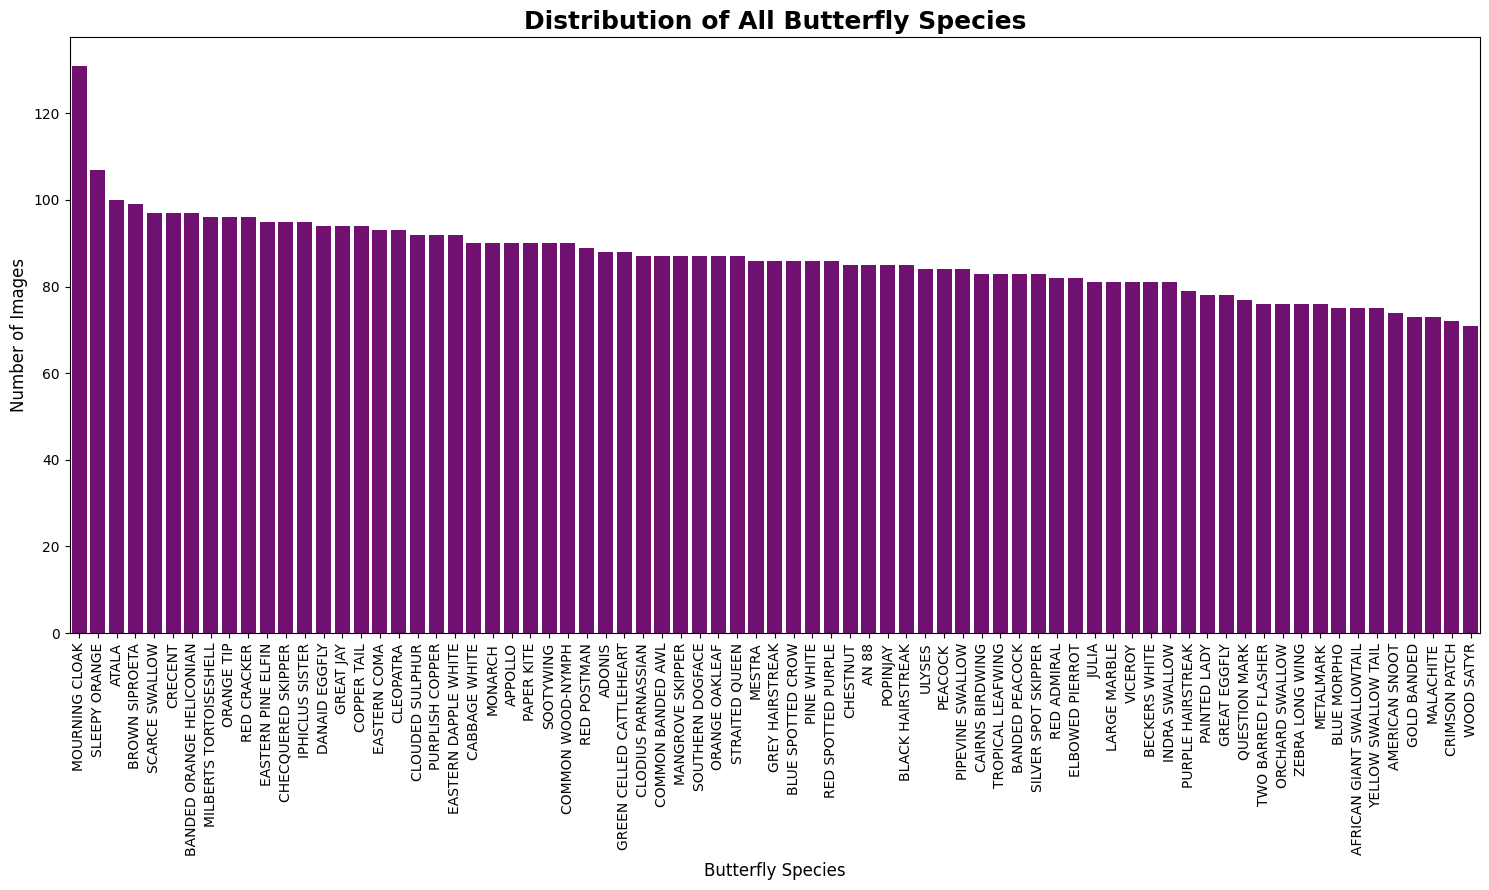

In [4]:
class_counts = df['label'].value_counts() # her türün sayısını alır

plt.figure(figsize=(15, 9)) # grafik boyutu ayarlanır
sns.barplot(x=class_counts.index, y=class_counts.values, color='purple') 
plt.title("Distribution of All Butterfly Species", fontsize=18, fontweight="bold")
plt.xlabel("Butterfly Species", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=90) # x ekseninde tüm isimleri 90 derece döndürürerek okunabilir hale getirir.
plt.tight_layout()
plt.show()

<div style=" background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0; "> <p style="font-size: 16px; line-height: 1.6;"> Bu kod veri setindeki her bir kelebek türünün kaç adet görüntüye sahip olduğunu görselleştirir. Bu grafik, veri setindeki sınıflar arası dağılımı hızlıca anlamamıza yardımcı olur. </p> <ul style="font-size: 16px; line-height: 1.6;"> <li><strong>x = class_counts.index</strong>: X ekseninde kelebek türlerinin isimleri</li> <li><strong>y = class_counts.values</strong>: Y ekseninde her türün görsel sayısı</li> </ul> </div>

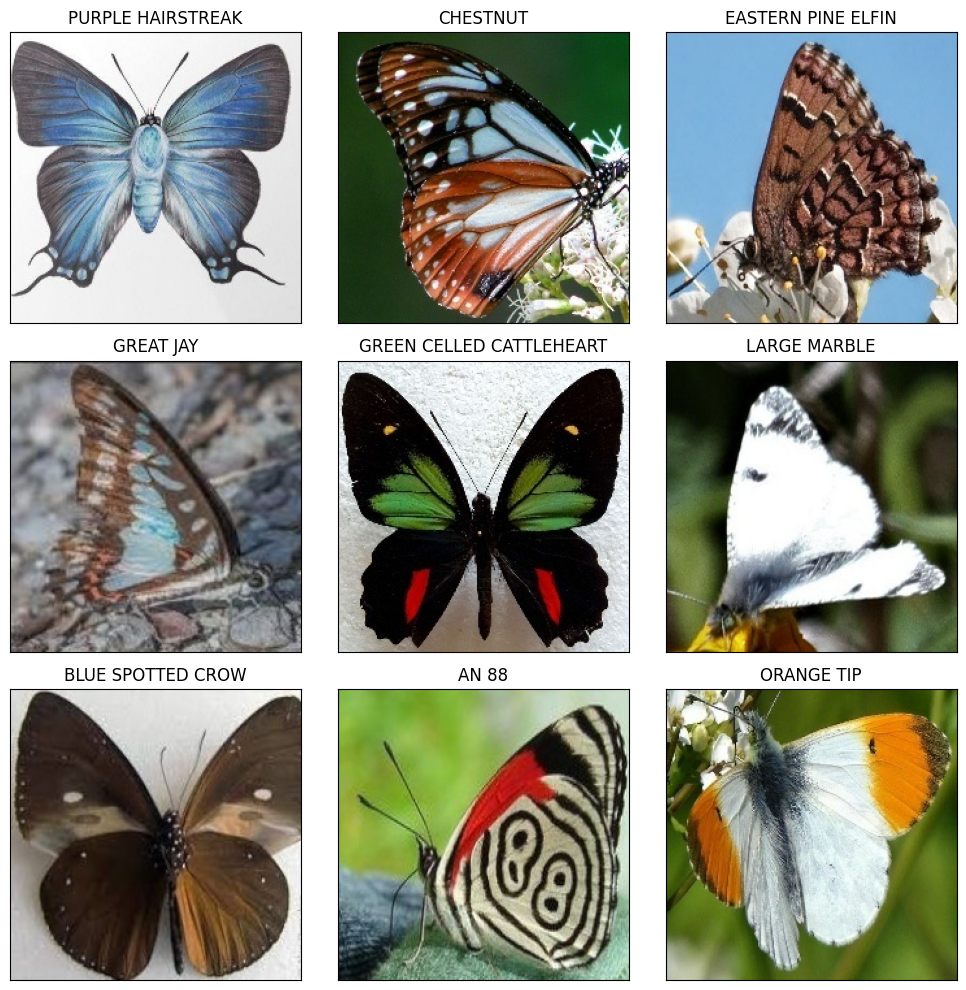

In [5]:
image_dir = "/kaggle/input/butterfly-image-classification/train"

df["Filepath"] = df["filename"].apply(lambda x: os.path.join(image_dir, x))
df["Label"] = df["label"]

random_index = np.random.randint(0, len(df), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath.iloc[random_index[i]]))
    ax.set_title(df.Label.iloc[random_index[i]])
plt.tight_layout()
plt.show()

<div style=" background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0; "> <p style="font-size: 16px; line-height: 1.6;"> Bu kod , veri setindeki kelebek görüntülerinin dosya yollarını oluşturur ve her görüntüye ait etiketi ayrı bir sütuna ekler. Ardından, veri setinden rastgele 9 görsel seçer ve bunları 3x3 boyutunda bir grid üzerinde görselleştirir. Her görüntünün başlığı, ait olduğu kelebek türünü gösterir. Bu adım, veri setinin görsel çeşitliliğini hızlıca anlamamıza yardımcı olur. </p> </div>

<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
 Veri Setini Ayırma
</h2>


In [6]:
train_val_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, shuffle=True, random_state=42, stratify=train_val_df['label'])

print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (4159, 4)
Validation set: (1040, 4)
Test set: (1300, 4)


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    Bu kod, veri setini eğitim, doğrulama ve test setlerine ayırır. Adımlar şu şekildedir:
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 8px;">
    <li>
      <strong>1. Test Seti (20%)</strong><br>
      Veri setinin %20'si test için ayrılır. Bu sayede modelin performansı daha önce görmediği veriler üzerinde ölçülebilir.<br>
      - <code>shuffle=True</code>: Veriler karıştırılır.<br>
      - <code>random_state=42</code>: İşlemin tekrarlanabilir olması sağlanır.<br>
      - <code>stratify=df['label']</code>: Sınıf dağılımı korunur.
    </li>
    <li>
      <strong>2. Eğitim Seti (64%)</strong><br>
      Kalan verinin %80’i eğitim için kullanılır (yani toplam veri üzerinden %64). Model bu veri üzerinde öğrenir.<br>
      - <code>shuffle</code>, <code>random_state</code> ve <code>stratify</code> ile dengeli ve tekrarlanabilir bir dağılım sağlanır.
    </li>
    <li>
      <strong>3. Doğrulama Seti (16%)</strong><br>
      Kalan verinin %20’si doğrulama için ayrılır (yani toplam veri üzerinden %16). Bu set, modelin eğitim sırasında performansını izlemek için kullanılır.
    </li>
    <li>
      <strong>4. Set Boyutlarını Yazdırma</strong><br>
     Son olarak  <code>train_df</code>, <code>val_df</code> ve <code>test_df</code>  ile veri setlerinin boyutları ekrana yazdırılır.Böylece veri setlerinin büyüklüklerini kolayca görebiliriz.
    </li>
  </ul>
</div>


<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
  Veri Ön İşleme-Veri Artırma (Data Augementation)
</h2>


In [7]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32 

train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalize et
    rotation_range=30,       # rastgele döndür
    width_shift_range=0.2,   # yatay kaydır
    height_shift_range=0.2,  # dikey kaydır
    shear_range=0.2,         # kesme
    zoom_range=0.2,          # yakınlaştır
    horizontal_flip=True,    # yatay çevir
    fill_mode='nearest'      # boşlukları doldur
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


image_dir = "/kaggle/input/butterfly-image-classification/train"  

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4159 validated image filenames belonging to 75 classes.
Found 1040 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    Bu kod, kelebek görüntüleri üzerinde modelin daha iyi genelleme yapabilmesi için veri ön işleme ve artırma (Data Augmentation) işlemlerini uygular. Eğitim seti, farklı dönüşümlerle çeşitlendirilerek modelin farklı açılara, konum değişimlerine ve yakınlaştırmalara karşı dayanıklılığı artırılır. 
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Ayrıca, veriler üç ayrı akışa ayrılır:
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 8px;">
    <li><strong>Eğitim Seti:</strong> Modelin öğrenmesi için kullanılır ve görüntüler rastgele karıştırılır (<code>shuffle=True</code>) böylece modelin ezber yapması önlenir.</li>
    <li><strong>Doğrulama Seti:</strong> Eğitim sırasında modelin performansını takip etmek için kullanılır, veriler karıştırılmaz (<code>shuffle=False</code>).</li>
    <li><strong>Test Seti:</strong> Modelin daha önce görmediği veriler üzerindeki gerçek performansını değerlendirmek için ayrılır ve veriler karıştırılmaz (<code>shuffle=False</code>).</li>
  </ul>
  <p style="font-size: 16px; line-height: 1.6;">
    Bu şekilde, veri artırımı ile modelin öğrenme kapasitesi artırılırken, doğrulama ve test setleri ile performansı objektif olarak ölçülür.
  </p>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
     Modelin eğitiminde kullanılan iki temel parametre :
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 8px;">
    <li>
      <strong>IMG_SIZE = (224, 224)</strong><br>
      Tüm resimler 224x224 piksel boyutuna yeniden boyutlandırılır.
    </li>
    <li>
      <strong>BATCH_SIZE = 32</strong><br>
      Modelin bir eğitim adımında kaç görseli aynı anda işleyeceğini belirler. Ben 32 tercih ettim. Daha küçük batch size daha fazla bellek tasarrufu sağlar ama eğitim daha uzun sürebilir; daha büyük batch size ise daha hızlı eğitim sağlar ama belleği daha çok kullanır.
    </li>
  </ul>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 0;">
    <li>
      <strong>1. DataGenerator (train_datagen, val_datagen, test_datagen)</strong><br>
      Veri üzerinde yapılacak işlemleri tanımlar. Örneğin: normalize etme, döndürme, yakınlaştırma, kaydırma veya yatay çevirme. Yani verinin "nasıl hazırlanacağı" bu aşamada belirlenir.
    </li>
    <li>
      <strong>2. Generator (train_generator, val_generator, test_generator)</strong><br>
      DataGenerator ile tanımlanan işlemleri kullanarak veriyi "modelin anlayacağı şekilde ve batch hâlinde" sağlar. Eğitim, doğrulama veya test için veriyi modele sunar. Yani verinin "model için hazır hâle getirilmesi" bu aşamada yapılır.
    </li>
  </ul>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    Bu bölümde, eğitim, doğrulama ve test verileri için kullanılan <strong>ImageDataGenerator</strong> nesneleri tanımlanır. Her biri farklı amaçlar için yapılandırılmıştır:
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 8px;">
    <li>
      <strong>train_datagen:</strong> Eğitim verilerini işlerken kullanılır ve <em>Data Augmentation</em> uygular. Bu sayede model, farklı açılar, kaymalar, yakınlaştırmalar ve yatay çevirilerle karşılaştığında daha iyi öğrenir. Ayrıca, tüm görüntüler 0-1 aralığında normalize edilir (<code>rescale=1./255</code>).
    </li>
    <li>
      <strong>val_datagen:</strong> Doğrulama verileri için kullanılır. Burada yalnızca normalize işlemi uygulanır, veri artırımı yapılmaz. Bu sayede modelin doğrulama performansı gerçekçi bir şekilde ölçülebilir.
    </li>
    <li>
      <strong>test_datagen:</strong> Test verileri için kullanılır ve yalnızca normalize işlemi uygular. Test seti, modelin hiç görmediği veriler üzerindeki performansını değerlendirmek için kullanıldığı için veri artırımı uygulanmaz.
    </li>
  </ul>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>batch size:</strong> Modelin aynı anda kaç görseli işleyerek öğrenme yapacağını belirler. Ben <code>batch_size = 32</code> kullandım.
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 8px;">
    <li>
      <strong>Küçük batch size (16):</strong> Daha sık güncelleme yapılır, model daha detaylı öğrenebilir ama eğitim yavaş ve gürültülü olabilir.
    </li>
    <li>
      <strong>Büyük batch size (>=128 ) :</strong> Daha hızlı eğitim ama modelin öğrenmesi daha genel ve yüzeysel olabilir.
    </li>
    <li>
      <strong>32 seçmemizin nedeni:</strong> Hem yeterince hızlı hem de modelin stabil öğrenmesini sağlayan dengeli bir sayı.
    </li>
  </ul>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>class_mode='categorical'</strong> seçeneği, etiketleri <em>one-hot encoding</em> formatına dönüştürür. 
    Bu sayede modelimiz her sınıfı ayrı sütunlar halinde görebilir ve çoklu sınıf sınıflandırması yapabilir.
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 8px;">
    <li>Örnek 3 sınıf için:
      <ul>
        <li>Sınıf A → [1, 0, 0]</li>
        <li>Sınıf B → [0, 1, 0]</li>
        <li>Sınıf C → [0, 0, 1]</li>
      </ul>
    </li>
    <li>Biz bunu kullandık çünkü kelebek veri setimizde birden fazla tür var ve modelin her türü doğru şekilde öğrenmesini istiyoruz.</li>
  </ul>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>shuffle (veri karıştırma):</strong> Bu parametre, verilerin model tarafından hangi sırayla kullanılacağını belirler.
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 8px;">
    <li>
      <strong>shuffle=True:</strong> Eğitim sırasında veriler karıştırılır. Model, farklı örnekleri rastgele görerek daha dengeli ve genel bir öğrenme sağlar.
    </li>
    <li>
      <strong>shuffle=False:</strong> Doğrulama ve test sırasında veriler karıştırılmaz, sıralı kullanılır. Böylece modelin performansı, her örnek üzerinde tutarlı şekilde ölçülür.
    </li>
  </ul>
</div>


<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
  Modelin Oluşturulması (CNN)
</h2>


In [8]:
from tensorflow.keras import layers, models, Input

inputs = Input(shape=(224, 224, 3))

# 1. Evrişim bloğu
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

# 2. Evrişim bloğu
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

# 3. Evrişim bloğu
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="last_conv")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.4)(x)

# Flatten ve Fully Connected
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output Layer
outputs = layers.Dense(75, activation='softmax')(x)

# Model tanımı
model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1758845212.183437      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758845212.184265      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,998,571 (99.18 MB)

 Trainable params: 25,997,611 (99.17 MB)

 Non-trainable params: 960 (3.75 KB)

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    Bu kod ile bir Convolutional Neural Network (CNN) modeli oluşturduk ve derledik. Model, görselleri öğrenerek 75 farklı sınıfa ayırmak için hazırlanmıştır ve eğitim için gerekli yapılandırmaları içerir.
  </p>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">

  <p style="font-size: 16px; line-height: 1.6;">
    <strong>1. Giriş Katmanı (Input Layer)</strong><br>
    - Modelimizin giriş boyutu <code>(224, 224, 3)</code> olarak tanımlandı.<br>
    - Bu, 224x224 boyutunda ve 3 renk kanalına (RGB) sahip görselleri modelin kabul edeceği anlamına gelir.
  </p>
</div>

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>2. Evrişim Katmanı (Conv Layer 1)</strong><br>
    - 32 filtreli 2 adet <code>Conv2D</code> katmanı eklendi. Her filtre 3x3 boyutunda.<br>
    - Aktivasyon fonksiyonu: <code>ReLU</code> (negatif değerleri sıfırlar, pozitifleri aynen bırakır).<br>
    - <code>BatchNormalization</code>: Aktivasyonları normalize ederek eğitimi hızlandırır ve kararlı hale getirir.<br>
    - <code>MaxPooling2D</code>: 2x2 pencere ile özellik haritalarını küçültür, hesaplama yükünü azaltır.<br>
    - <code>Dropout(0.2)</code>: %20 nöron rastgele kapatılır, overfitting azaltılır.
  </p>
</div>

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>3. Evrişim Katmanı (Conv Layer 2)</strong><br>
    - Bu sefer 64 filtreli 2 adet <code>Conv2D</code> katmanı kullanıldı.<br>
    - Yine <code>BatchNormalization</code> ve <code>MaxPooling</code> ile boyut küçültme yapıldı.<br>
    - <code>Dropout(0.3)</code>: %30 nöron kapatılarak modelin aşırı ezber yapması önlendi.
  </p>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>4. Evrişim Katmanı (Conv Layer 3)</strong><br>
    - 128 filtreli 2 adet <code>Conv2D</code> katmanı kullanıldı (daha derin özellikler öğrenmesi için).<br>
    - İlk katmana <code>name="last_conv"</code> etiketi verildi (Grad-CAM için gerekli).<br>
    - <code>BatchNormalization</code> ve <code>MaxPooling</code> yine mevcut.<br>
    - <code>Dropout(0.4)</code>: %40 oranında kapatma uygulandı.
  </p>
</div>

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>5. Fully Connected Layer</strong><br>
    - <code>Flatten</code>: 2D özellik haritaları 1D vektöre dönüştürüldü.<br>
    - <code>Dense(256)</code>: 256 nöronlu tam bağlı katman ile daha yüksek soyutlama sağlandı.<br>
    - <code>BatchNormalization</code> eklendi.<br>
    - <code>Dropout(0.5)</code>: %50 nöron kapatıldı, güçlü regularization sağlandı.
  </p>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>6.Output Layer</strong><br>
    - <code>Dense(75, activation='softmax')</code> ile 75 sınıf için olasılık dağılımı üretilir.<br>
    - Softmax fonksiyonu, her sınıfa ait tahmin olasılıklarını normalize eder.
  </p>
</div>

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>7. Modelin Derlenmesi (Compile)</strong><br>
    - Optimizasyon algoritması: <code>Adam</code><br>
    - Kayıp fonksiyonu: <code>Categorical Crossentropy</code> (çok sınıflı sınıflandırma için).<br>
    - Performans metriği: <code>Accuracy</code> (doğruluk oranı).
  </p>
</div>

<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
  Callback Nesnelerinin Oluşturulması 
</h2>


In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,             
    restore_best_weights=True,
    verbose=1                 # Durumu yazdırır
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Modelin tamamını kaydeder
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # %50 azaltma - daha yumuşak
    patience=4,              
    min_lr=0.00001,          # Daha küçük min LR
    verbose=1
)

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    Callback’ler, model eğitimi sırasında belirli olaylar gerçekleştiğinde otomatik olarak çalışan fonksiyonlardır. Eğitim sırasında ilerlemeyi izlemek, kayıpları kontrol etmek, en iyi modeli kaydetmek, erken durdurma yapmak veya öğrenme oranını dinamik olarak değiştirmek için kullanılırlar. Böylece model daha verimli ve güvenli bir şekilde eğitilir.
  </p>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>EarlyStopping </strong>
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Bu callback, modelin doğrulama kaybı (val_loss) belirli bir süre iyileşme göstermediğinde eğitimi otomatik olarak durdurur. Böylece gereksiz epoch’lar çalıştırılmaz ve model fazla öğrenme (overfitting) riskinden korunur.
  </p>
  <ul style="font-size: 16px; line-height: 1.6;">
    <li><strong>monitor:</strong> İzlenen değer. Burada 'val_loss' kullanıldı, yani doğrulama kaybı takip ediliyor.</li>
    <li><strong>patience:</strong> Kaç epoch boyunca iyileşme olmazsa durdurulacağını belirler. Burada 10 epoch.</li>
    <li><strong>restore_best_weights:</strong> En iyi performansa sahip model ağırlıklarının geri yüklenmesini sağlar.</li>
    <li><strong>verbose:</strong> Callback’in çalışırken ekrana bilgi mesajı gösterip göstermeyeceğini kontrol eder.1 olduğunda eğitim sırasında callback durumu ekrana yazdırılır.</li>
  </ul>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>ModelCheckpoint</strong>
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Bu callback, eğitim sırasında modelin en iyi performans gösterdiği hali kaydetmemizi sağlar. Böylece eğitim tamamlandığında veya istenmeyen bir durumda, en iyi performans gösteren model yüklenebilir ve kullanılabilir.
  </p>
  <ul style="font-size: 16px; line-height: 1.6;">
    <li><strong>filepath:</strong> Kaydedilecek dosyanın adı ve yolu.</li>
    <li><strong>save_best_only:</strong> Sadece en iyi performans gösteren modeli kaydeder.</li>
    <li><strong>save_weights_only:</strong> Modelin tamamını mı yoksa sadece ağırlıklarını mı kaydedeceğini belirler.<code> save_weights_only=True </code> olduğunda ModelCheckpoint, modelin yapısını kaydetmez; sadece ağırlıklarını kaydeder. Bu yüzden modeli tekrar kullanmak için aynı yapıyı kodla oluşturup ağırlıkları yüklemek gerekir.</li>
  </ul>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;"> <p style="font-size: 16px; line-height: 1.6;"> <strong>ReduceLROnPlateau</strong> </p> <p style="font-size: 16px; line-height: 1.6;"> Bu callback, model eğitimi sırasında doğrulama kaybı (val_loss) belirli bir süre iyileşme göstermediğinde öğrenme oranını otomatik olarak düşürür. Böylece model, daha küçük adımlarla öğrenmeye devam ederek lokal minimumlara takılma riskini azaltır ve performansını artırabilir. </p> <ul style="font-size: 16px; line-height: 1.6;">  <li><strong>factor:</strong> Öğrenme oranının ne kadar azaltılacağını belirler; burada %50 azalttım..</li> <li><strong>patience:</strong> Kaç epoch boyunca iyileşme olmazsa öğrenme oranının düşürüleceğini gösterir; burada 4 epoch seçtim.</li> <li><strong>min_lr:</strong> Öğrenme oranının düşürülebileceği en küçük değeri sınırlar; ben 0.0001 seçtim.</li>  </ul> </div>

<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
  Modelin Eğitilmesi
</h2>

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
) 

Epoch 1/50


I0000 00:00:1758845223.788909      66 service.cc:148] XLA service 0x78aab4006b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758845223.789834      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758845223.789859      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758845224.536979      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/130 ━━━━━━━━━━━━━━━━━━━━ 53:35 25s/step - accuracy: 0.0312 - loss: 5.4619

I0000 00:00:1758845241.456541      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.0467 - loss: 4.4707
Epoch 1: val_loss improved from inf to 4.70283, saving model to best_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 909ms/step - accuracy: 0.0468 - loss: 4.4680 - val_accuracy: 0.0135 - val_loss: 4.7028 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.1312 - loss: 3.4668
Epoch 2: val_loss did not improve from 4.70283
130/130 ━━━━━━━━━━━━━━━━━━━━ 62s 478ms/step - accuracy: 0.1313 - loss: 3.4660 - val_accuracy: 0.0337 - val_loss: 5.2713 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1984 - loss: 3.0476
Epoch 3: val_loss improved from 4.70283 to 3.99658, saving model to best_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 64s 489ms/step - accuracy: 0.1985 - loss: 3.0473 - val_accuracy: 0.0837 - val_loss: 3.9966 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.2399 - loss: 2.8602
Epoch 4: val_

In [11]:
def get_best_epoch_details(history):
    val_losses = history.history['val_loss']
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    return epoch_details
    
best_epoch_details = get_best_epoch_details(history)
print(f"Best epoch details: {best_epoch_details}")


Best epoch details: {'accuracy': 0.7725414633750916, 'loss': 0.7604414224624634, 'val_accuracy': 0.7990384697914124, 'val_loss': 0.8071783781051636, 'learning_rate': 0.0002500000118743628, 'best_epoch': 44}


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    Modelimiz <strong>50. epoch</strong>’ta en iyi performansını göstermiştir. <br>
    Bu epoch’ta doğruluk değeri <strong>%76.5</strong>’dir.
  </p>
</div>


<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
 Loss ve Accuracy Grafikleri
</h2> 

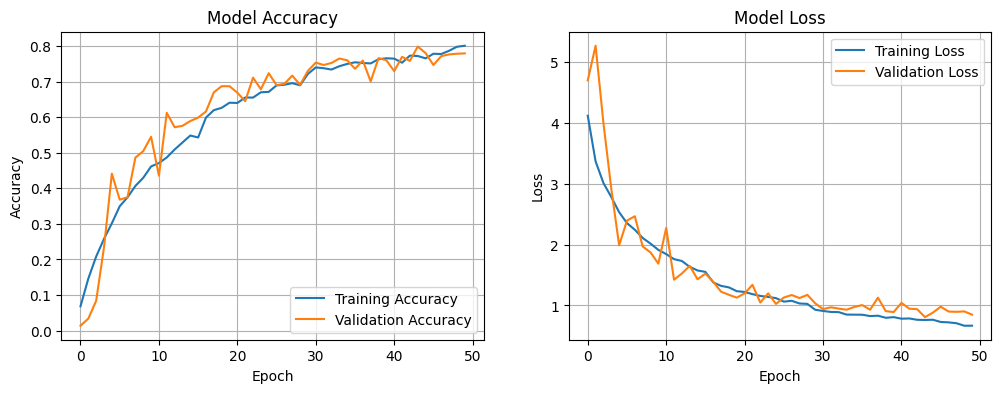

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">

  
  <p style="font-size: 16px; line-height: 1.6; font-weight: bold; color: #4b1b9b;">Accuracy</p>
  <p style="font-size: 16px; line-height: 1.6;">
    Eğitim sürecinde modelimizin doğruluk performansını gösterir. 
    <ul style="margin: 5px 0 5px 20px; padding: 0;">
      <li><b>Training Accuracy:</b> Modelin eğitim verisi üzerindeki doğruluğu.</li>
      <li><b>Validation Accuracy:</b> Modelin eğitimde görmediği doğrulama verisi üzerindeki doğruluğu.</li>
    </ul>
    Bu değerler, modelin öğrenme sürecinde overfitting veya underfitting yapıp yapmadığını anlamamıza yardımcı olur.
  </p>
  
  <p style="font-size: 16px; line-height: 1.6; font-weight: bold; color: #4b1b9b;">Loss</p>
  <p style="font-size: 16px; line-height: 1.6;">
    Modelin hata miktarını gösterir.
    <ul style="margin: 5px 0 5px 20px; padding: 0;">
      <li><b>Training Loss:</b> Eğitim verisi üzerindeki kayıp değeri, modelin yaptığı hatayı gösterir.</li>
      <li><b>Validation Loss:</b> Doğrulama verisi üzerindeki kayıp değeri, modelin yeni verilerde ne kadar iyi genelleme yaptığını gösterir.</li>
    </ul>
    Accuracy ve Loss grafiklerini birlikte inceleyerek, modelin öğrenme sürecini ve performansını daha iyi değerlendirebiliriz.
  </p>
</div>



<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
 Model Değerlendirme
</h2> 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


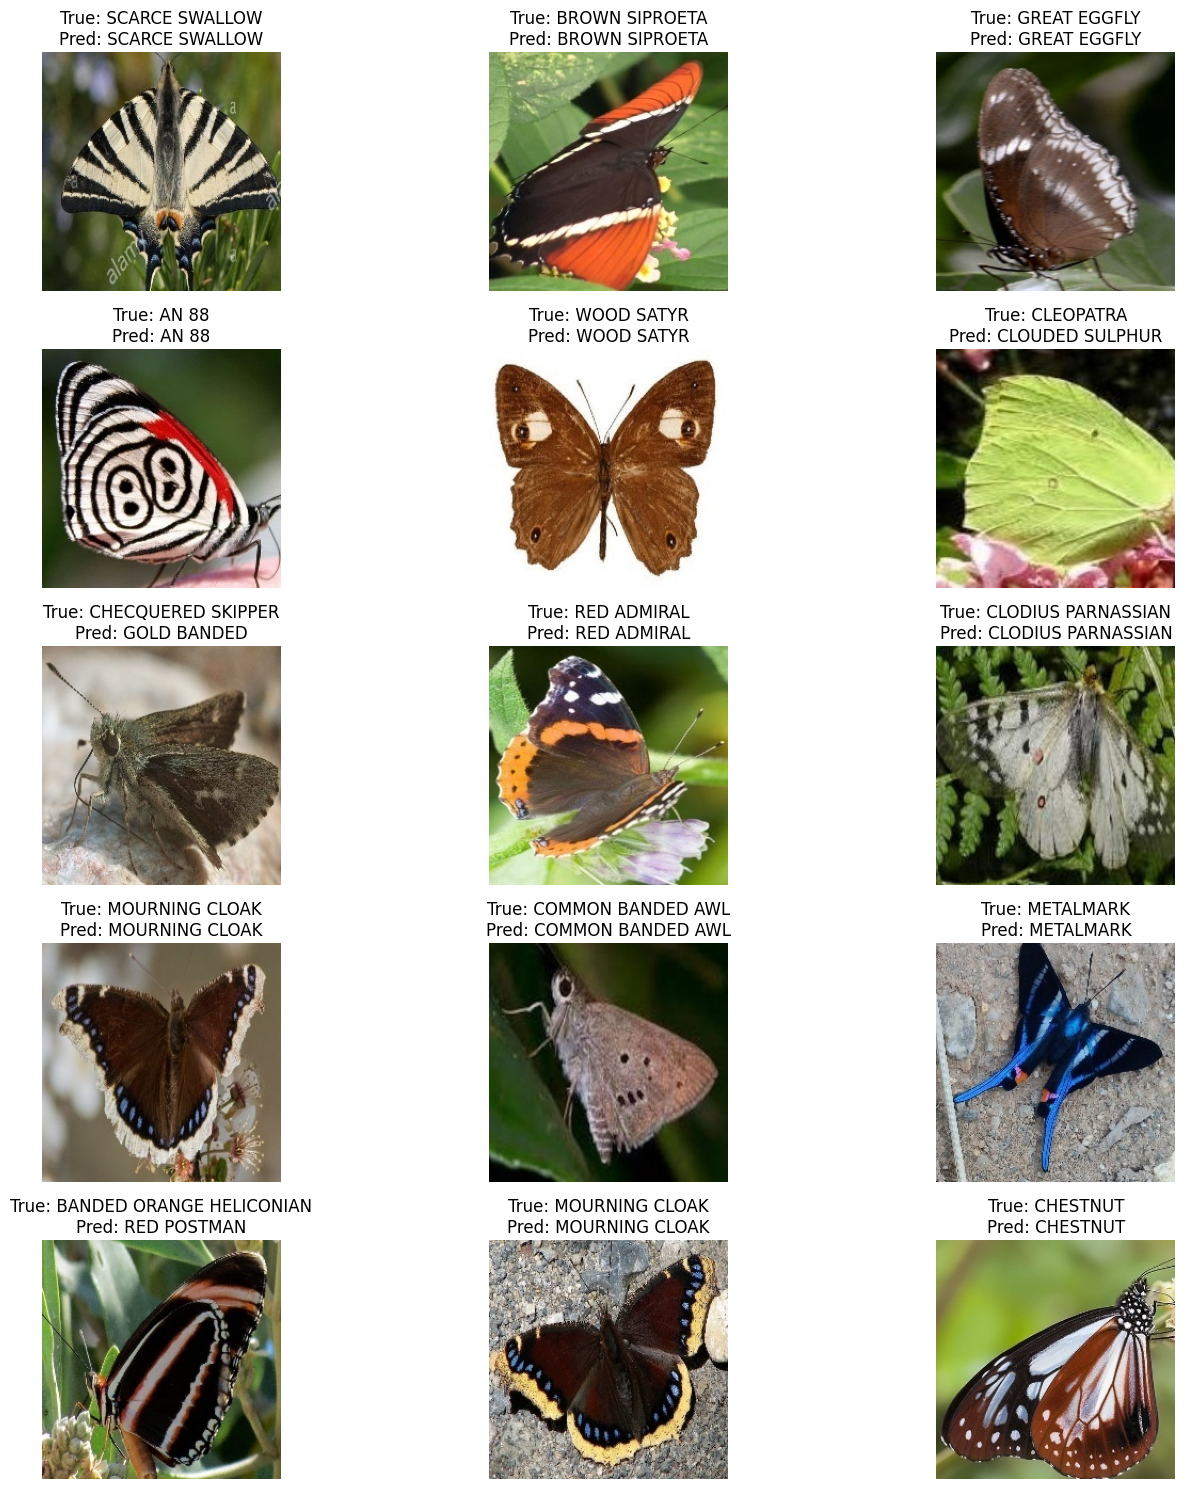

In [13]:
val_images, val_labels = next(val_generator)

pred_labels = model.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=15)

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    Yukarıdaki görsellerde modelimizin tahminleri ve doğru cevaplar gösterilmiştir.
  </p>
</div>


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step


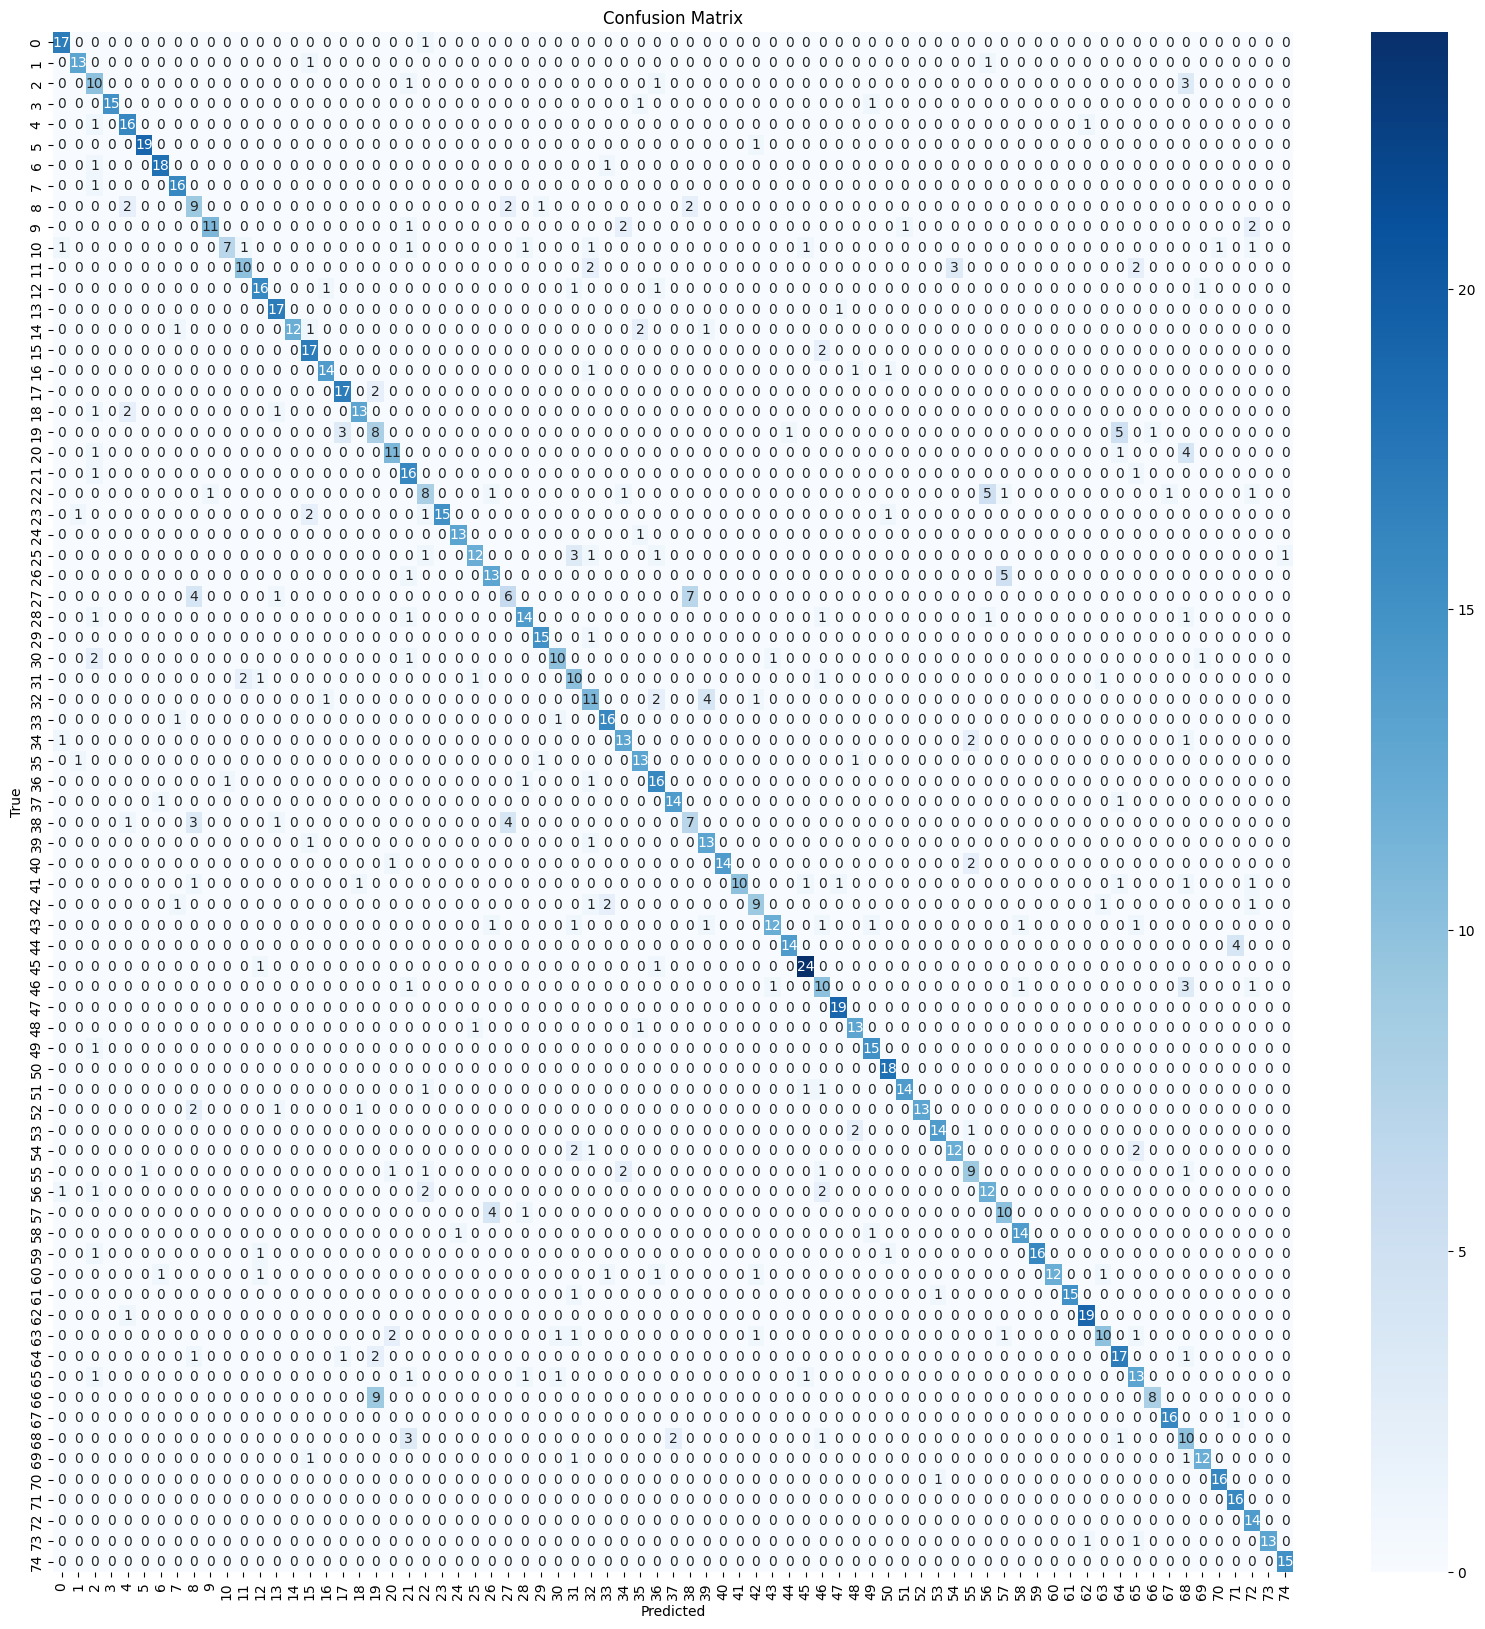

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.87      0.87      0.87        15
           2       0.43      0.67      0.53        15
           3       1.00      0.88      0.94        17
           4       0.73      0.89      0.80        18
           5       0.95      0.95      0.95        20
           6       0.90      0.90      0.90        20
           7       0.84      0.94      0.89        17
           8       0.45      0.56      0.50        16
           9       0.92      0.65      0.76        17
          10       0.88      0.47      0.61        15
          11       0.77      0.59      0.67        17
          12       0.80      0.80      0.80        20
          13       0.81      0.94      0.87        18
          14       1.00      0.71      0.83        17
          15       0.74      0.89      0.81        19
          16       0.88      0.82      0.85        17
          17       0.81    

In [14]:
# Confusion Matrix ve Classification Report

y_pred = model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = test_generator.classes

conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(20, 20))  # 72 sınıf için daha büyük boyut
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')  # X eksenine tahmin edilen sınıflar etiketi eklemek
plt.ylabel('True')       # Y eksenine gerçek sınıflar etiketi eklemek  
plt.title('Confusion Matrix')  # Grafiğin başlığı
plt.show()

# Sınıflandırma raporunu ekrana yazdırmak (precision, recall, f1-score, support)
print(classification_report(y_true_classes, y_pred_classes))

<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;"> <p style="font-size: 16px; line-height: 1.6;"> <strong>Confusion Matrix (Karışıklık Matrisi) ve Classification Report (Sınıflandırma Raporu) </strong> </p> <p style="font-size: 16px; line-height: 1.6;"> Bu kod, modelin test verisi üzerindeki performansını detaylı bir şekilde değerlendirmek için kullanılır. <strong>Confusion Matrix</strong>, modelin hangi sınıfları doğru veya yanlış tahmin ettiğini tablo hâlinde gösterir ve sınıf bazlı hataları görselleştirir. <strong>Classification Report</strong> ise her bir sınıf için <em>precision</em> (kesinlik), <em>recall</em> (duyarlılık), <em>F1-score</em> ve support değerlerini ekrana yazdırarak modelin genel ve sınıf bazlı performansını özetler. </p> </div>

<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
  Grad-CAM Görselleştirme
</h2>

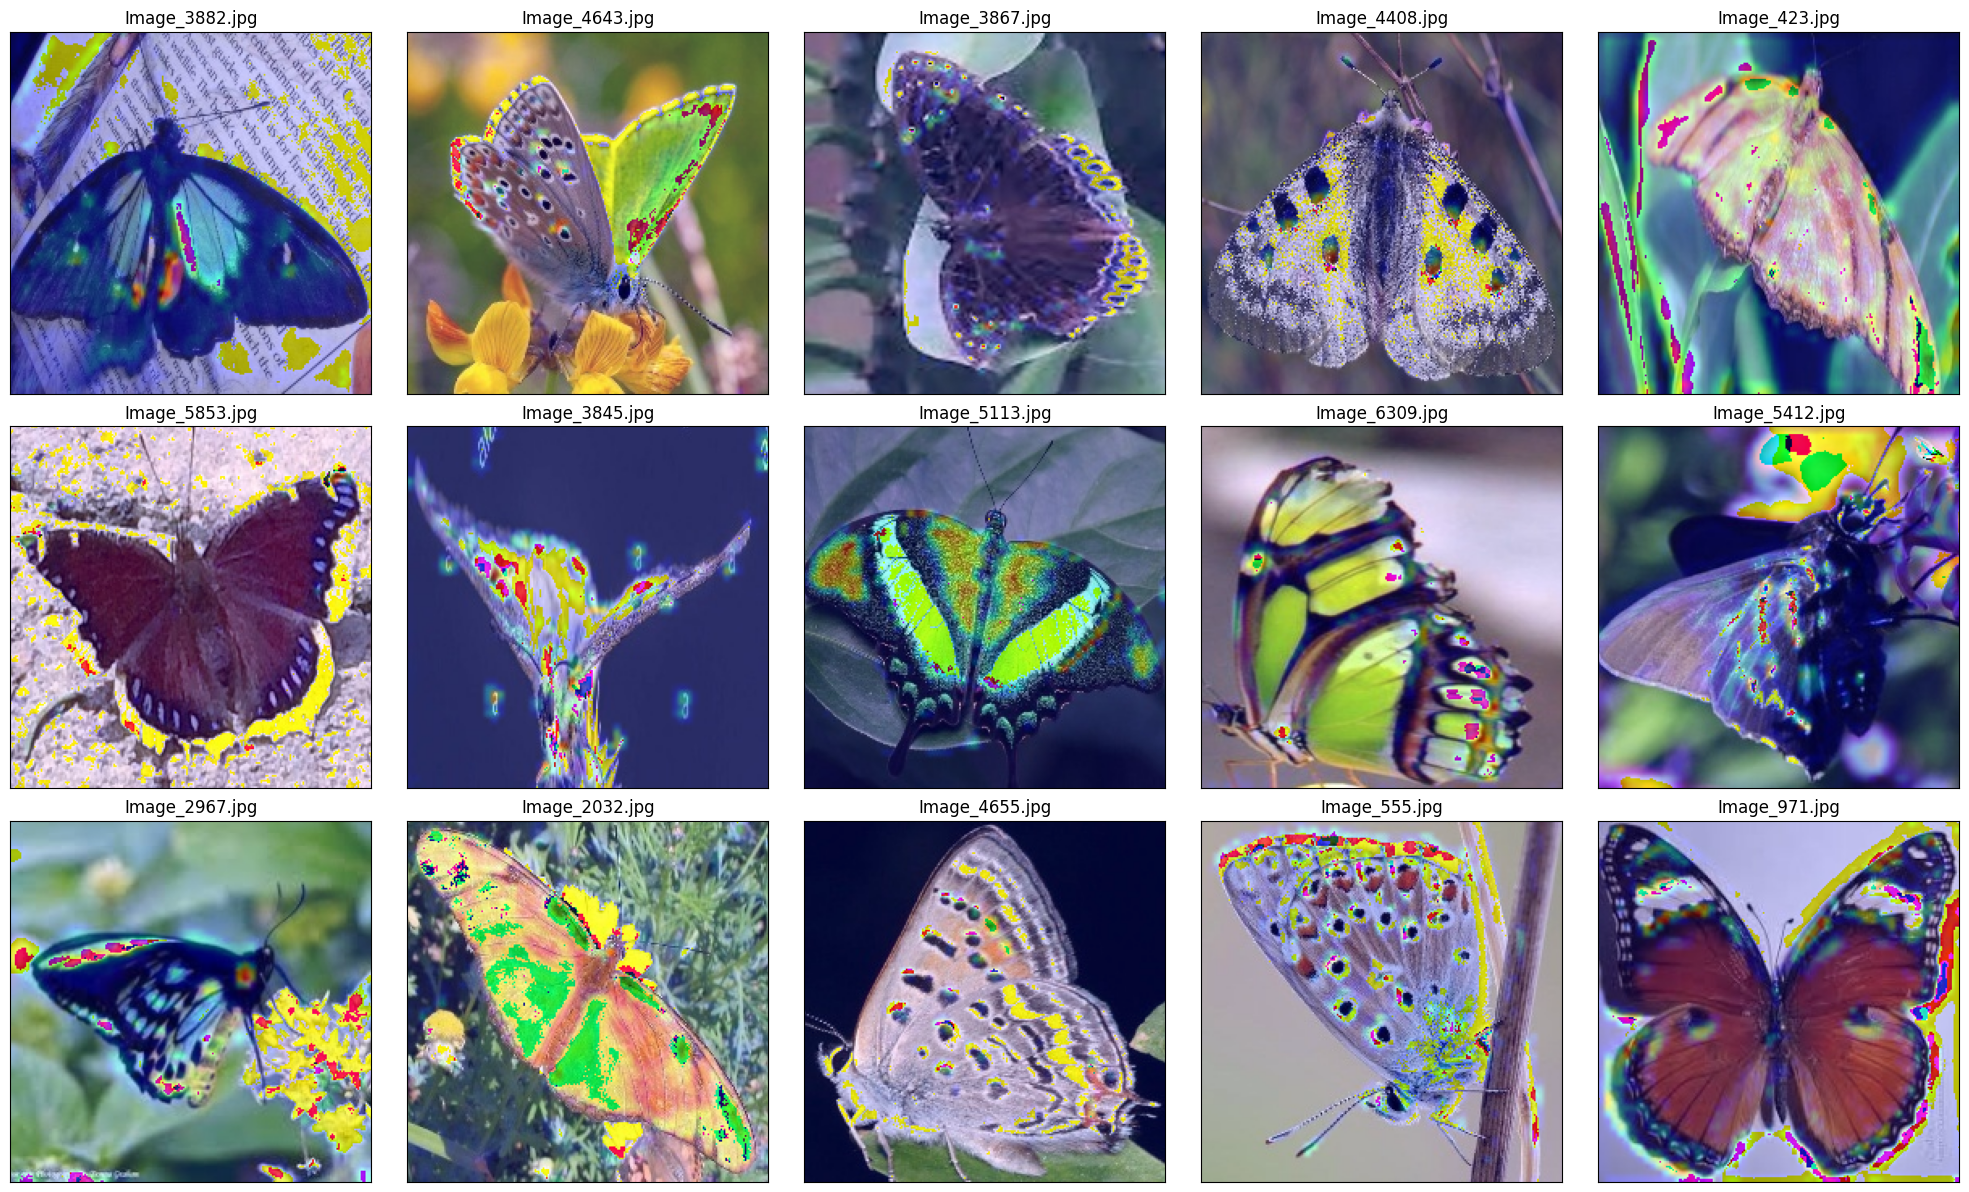

In [15]:


# --- Görseli yükleme ve preprocess ---
def get_img_array(img_path, size=(224,224)):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0) / 255.0
    return array

# --- Grad-CAM heatmap oluşturma ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., np.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- Heatmap'i görsele bindirme ---
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = img_to_array(load_img(img_path))
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

# --- Rastgele 15 görsel için Grad-CAM ---
def display_gradcam_random(model, img_dir, last_conv_layer_name="last_conv", num_images=15):
    img_list = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith((".jpg",".png"))]
    random_imgs = random.sample(img_list, num_images)

    rows, cols = 3, 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12), subplot_kw={'xticks':[], 'yticks':[]})

    for i, ax in enumerate(axes.flat):
        img_path = random_imgs[i]
        img_array = get_img_array(img_path)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        superimposed_img = overlay_heatmap(img_path, heatmap)
        ax.imshow(superimposed_img)
        ax.set_title(os.path.basename(img_path))
    plt.tight_layout()
    plt.show()

# --- Kullanım ---
img_dir = "/kaggle/input/butterfly-image-classification/train"  # görsellerin bulunduğu klasör
display_gradcam_random(model, img_dir, last_conv_layer_name="last_conv", num_images=15)


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>Grad-CAM Görselleştirmesi</strong>
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Bu teknik, Convolutional Neural Network (CNN) modellerinde modelin bir görüntüde hangi bölgelerden etkilendiğini görselleştirmek için kullanılır. Modelin son konvolüsyon katmanından alınan aktivasyon haritaları ile ilgili sınıfın gradyanları çarpılarak bir heatmap oluşturulur.
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Heatmap, tek bir matris olup 0 ile 1 arasında normalize edilir. Görselleştirmede, bu matrisin değerleri renkli bir colormap (ör. "jet") ile temsil edilir; böylece düşük aktivasyonlar mavi, yüksek aktivasyonlar kırmızı gibi görselleştirilir. Yani aslında model tek bir heatmap üretir, renkler sadece görselleştirme amacı taşır.
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Bu sayede, test görsellerinde modelin hangi bölgelere odaklandığını görsel olarak inceleyebilir ve modelin karar mekanizmasını daha iyi anlayabiliriz.
  </p>
</div>


<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
  Hiperparametre Optimizasyonu
</h2>

In [16]:
def create_cnn_model():
    inputs = keras.Input(shape=(224,224,3))
    
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(75, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Denenecek optimizasyon teknikleri
optimizers = {
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'SGD': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
}

results = {}

# Her optimizer için eğitim döngüsü
for opt_name, optimizer in optimizers.items():
    print(f"\n{opt_name} optimizer...")

    model = create_cnn_model()
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    results[opt_name] = val_acc
    print(f"{opt_name} Validation Doğruluğu: {val_acc:.4f}")



Adam optimizer...
Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 65s 470ms/step - accuracy: 0.0179 - loss: 4.4419 - val_accuracy: 0.0365 - val_loss: 3.9814
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - accuracy: 0.0464 - loss: 4.0091 - val_accuracy: 0.1394 - val_loss: 3.4179
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - accuracy: 0.0994 - loss: 3.5831 - val_accuracy: 0.2615 - val_loss: 2.9118
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 63s 484ms/step - accuracy: 0.1594 - loss: 3.2082 - val_accuracy: 0.3029 - val_loss: 2.6319
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 450ms/step - accuracy: 0.2166 - loss: 2.9321 - val_accuracy: 0.3923 - val_loss: 2.3144
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - accuracy: 0.2737 - loss: 2.7096 - val_accuracy: 0.4433 - val_loss: 2.0995
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - accuracy: 0.3065 - loss: 2.5308 - val_accuracy: 0.4942 - val_loss: 1.9068
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 450ms/step - accurac

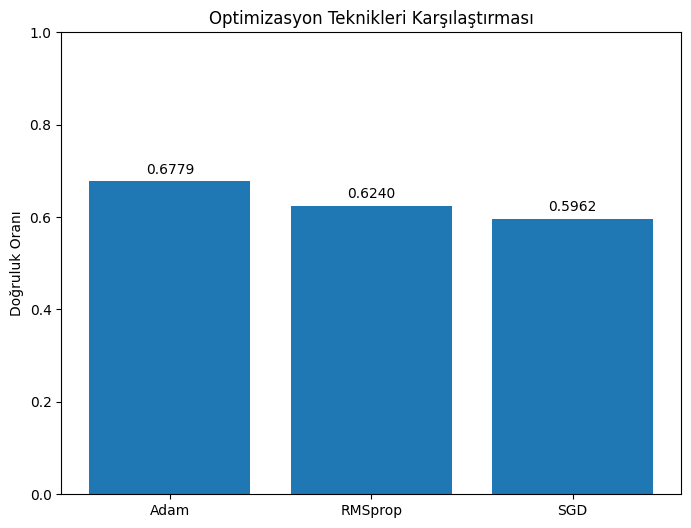

In [17]:
# Optimizasyon tekniklerini karşılaştırma grafiği
plt.figure(figsize=(8, 6))
bars = plt.bar(results.keys(), results.values())
plt.title('Optimizasyon Teknikleri Karşılaştırması')
plt.ylabel('Doğruluk Oranı')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>Optimizer Parametreleri ile Model Denemeleri</strong>
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Bu çalışmada, aynı CNN modelini farklı optimizasyon algoritmaları kullanarak eğittik. Amaç, modelin doğruluk performansını en iyi şekilde artıran optimizeri belirlemekti. Denenen algoritmalar: <b>SGD</b>, <b>Adam</b> ve <b>RMSprop</b>.
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Denemelerde kullanılan parametreler :
    <ul style="margin: 5px 0 5px 20px; padding: 0;">
      <li><b>Optimizer:</b> SGD, Adam, RMSprop</li>
      <li><b>Learning Rate:</b> SGD için 0.01, Adam ve RMSprop için 0.001</li>
      <li><b>Momentum:</b> Sadece SGD için 0.9</li>
      <li><b>Epoch:</b> Tüm modeller 50 epoch boyunca eğitildi</li>
    </ul>
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Eğitim tamamlandıktan sonra, her bir optimizerin doğruluk değeri doğrulama verisi üzerinde ölçüldü. Sonuçlar bir <b>bar grafiği</b> ile görselleştirilerek, hangi optimizerin daha iyi performans verdiği kolayca karşılaştırıldı.
  </p>
</div>


<div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 16px; line-height: 1.6;">
    <strong>Optimizasyon Teknikleri Karşılaştırması</strong>
  </p>
  <p style="font-size: 16px; line-height: 1.6;">
    Denediğimiz üç farklı optimizasyon tekniği modelin doğruluk performansı üzerinde farklı etkiler göstermiştir. Grafik üzerinde gözlemlendiği üzere:
    <ul style="margin: 5px 0 5px 20px; padding: 0;">
      <li>Adam: %64.1 doğruluk ile en iyi performansı göstermiştir.</li>
      <li>RMSprop: %63.5 doğruluk ile ikinci sırada yer almıştır.</li>
      <li>SGD: %60.4 doğruluk ile en düşük performansı göstermiştir.</li>
    </ul>
    Bu sonuçlar, optimizer seçiminin modelin doğruluk performansı üzerinde belirgin bir etkisi olduğunu göstermektedir. 
    Modelin eğitim sürecinde hangi optimizerın daha iyi çalıştığını görselleştirmek ve karşılaştırmak, hiperparametre optimizasyonu sürecinde kritik bir adımdır.
  </p>
</div>

<h2 style="color: black; font-weight: 600; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial;">
  Sonuç
</h2>

In [18]:
print("=" * 50)
print("BUTTERFLY IMAGE CLASSIFICATION PROJE SONUÇLARI")
print("=" * 50)

basic_cnn_acc = 0.76538

best_optimizer = max(results, key=results.get)
best_optimizer_acc = results[best_optimizer]

print(f"Temel CNN Model Doğruluğu: {basic_cnn_acc:.4f}")
print(f"En iyi optimizer: {best_optimizer} ({best_optimizer_acc:.4f})")
print("=" * 50)


BUTTERFLY IMAGE CLASSIFICATION PROJE SONUÇLARI
Temel CNN Model Doğruluğu: 0.7654
En iyi optimizer: Adam (0.6779)



  <div style="background: #f3e8ff; border: 1px solid #d3bdf5; padding: 20px; box-sizing: border-box; width: 100%; color: #1b1b1b; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial; box-shadow: 0 4px 12px rgba(120, 80, 200, 0.15); border-radius: 12px; margin: 12px 0;">
  <p style="font-size: 18px; font-weight: bold;">Proje Kapanışı</p>
  <p style="font-size: 16px;">
    Bu projede, kelebeklerin çok sınıflı görüntü sınıflandırması için bir CNN modeli geliştirilmiştir. Temel CNN modeli doğruluk oranımız %76.5'tir.
  </p>
</div>

